## Default of Credit Card Clients

Dataset

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

Content
There are 25 variables:

ID: ID of each client

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

AGE: Age in years

PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

default.payment.next.month: Default payment (1=yes, 0=no)

## Librerias 

In [1]:
!pip install imbalanced-learn
!pip install joblib
!pip install pydotplus
!pip install pydot
!pip install graphviz
!pip install Pillow
!pip install Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime 
%matplotlib inline

## Carga Datos 

In [2]:
df0 = pd.read_excel(r'https://github.com/joatamayoav/Trabajo_Final_Analitica_Predictiva/blob/main/default_of_credit_card_clients.xls?raw=true',
     header=1,
    )

df0.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df0.rename(columns=lambda x: x.lower(), inplace=True)
df0.rename(columns={"default payment next month":"default"}, inplace=True) 

df0.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
#
# Se crea copia del Dataframe original para no dañarlo
#

df = df0.copy()

df.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Variables Dummys 

Variable ficticia para explicar valores cualitativos en un modelo de regresión.

In [5]:
df['grad_school'] = (df0["education"] == 1).astype(int)
df['university'] = (df0["education"] == 2).astype(int)
df['high_school'] = (df0["education"] == 3).astype(int)
df.drop("education", axis = 1, inplace = True)

df['male'] = (df0["sex"] == 1).astype(int)
df['female'] = (df0["sex"] == 2).astype(int)
df.drop("sex", axis = 1, inplace = True)

df['single'] = (df0["marriage"] == 2).astype(int)
df['married'] = (df0["marriage"] == 1).astype(int)
df.drop("marriage", axis = 1, inplace = True)

df.head(10)

,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,female,single,married
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,0,0,1,0,1,0,0,1,0,1
1,2,120000,26,-1,2,0,0,0,2,2682,...,0,2000,1,0,1,0,0,1,1,0
2,3,90000,34,0,0,0,0,0,0,29239,...,1000,5000,0,0,1,0,0,1,1,0
3,4,50000,37,0,0,0,0,0,0,46990,...,1069,1000,0,0,1,0,0,1,0,1
4,5,50000,57,-1,0,-1,0,0,0,8617,...,689,679,0,0,1,0,1,0,0,1
5,6,50000,37,0,0,0,0,0,0,64400,...,1000,800,0,1,0,0,1,0,1,0
6,7,500000,29,0,0,0,0,0,0,367965,...,13750,13770,0,1,0,0,1,0,1,0
7,8,100000,23,0,-1,-1,0,0,-1,11876,...,1687,1542,0,0,1,0,0,1,1,0
8,9,140000,28,0,0,2,0,0,0,11285,...,1000,1000,0,0,0,1,0,1,0,1
9,10,20000,35,-2,-2,-2,-2,-1,-1,0,...,1122,0,0,0,0,1,1,0,1,0


In [6]:
pay_features = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for p in pay_features:
    df.loc[df[p] <= 0, p] = 0

df.head()

,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,female,single,married
0,1,20000,24,2,2,0,0,0,0,3913,...,0,0,1,0,1,0,0,1,0,1
1,2,120000,26,0,2,0,0,0,2,2682,...,0,2000,1,0,1,0,0,1,1,0
2,3,90000,34,0,0,0,0,0,0,29239,...,1000,5000,0,0,1,0,0,1,1,0
3,4,50000,37,0,0,0,0,0,0,46990,...,1069,1000,0,0,1,0,0,1,0,1
4,5,50000,57,0,0,0,0,0,0,8617,...,689,679,0,0,1,0,1,0,0,1


## Análisis Descriptivo

In [7]:
sorted(df.columns)

['age',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'default',
 'female',
 'grad_school',
 'high_school',
 'id',
 'limit_bal',
 'male',
 'married',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'single',
 'university']

In [8]:
df.dtypes

id             int64
limit_bal      int64
age            int64
pay_0          int64
pay_2          int64
pay_3          int64
pay_4          int64
pay_5          int64
pay_6          int64
bill_amt1      int64
bill_amt2      int64
bill_amt3      int64
bill_amt4      int64
bill_amt5      int64
bill_amt6      int64
pay_amt1       int64
pay_amt2       int64
pay_amt3       int64
pay_amt4       int64
pay_amt5       int64
pay_amt6       int64
default        int64
grad_school    int32
university     int32
high_school    int32
male           int32
female         int32
single         int32
married        int32
dtype: object

In [9]:
df.shape

(30000, 29)

In [10]:
df.describe()

,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,female,single,married
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,35.485500,0.356767,0.320033,0.304067,0.258767,0.22150,0.226567,51223.330900,...,4799.387633,5215.502567,0.221200,0.352833,0.467667,0.163900,0.396267,0.603733,0.532133,0.455300
std,8660.398374,129747.661567,9.217904,0.760594,0.801727,0.790589,0.761113,0.71772,0.715438,73635.860576,...,15278.305679,17777.465775,0.415062,0.477859,0.498962,0.370191,0.489129,0.489129,0.498975,0.498006
min,1.000000,10000.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-165580.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3558.750000,...,252.500000,117.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.500000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,22381.500000,...,1500.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,22500.250000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,67091.000000,...,4031.500000,4000.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,30000.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,964511.000000,...,426529.000000,528666.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Análisis Exploratorio

In [11]:
# Cantidad de nulos

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,married,bill_amt5,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,...,pay_amt4,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,female,id
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


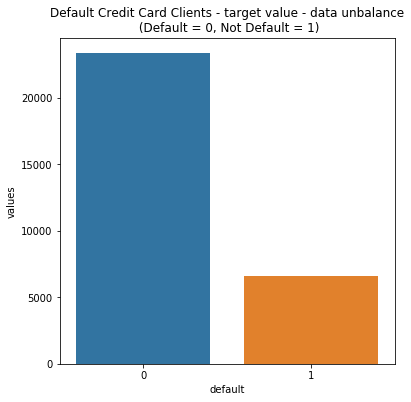

,default,values
0,0,23364
1,1,6636


In [12]:
temp = df["default"].value_counts()

df1 = pd.DataFrame({'default': temp.index,'values': temp.values})

plt.figure(figsize = (6,6))

plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')

sns.set_color_codes("pastel")
sns.barplot(x = 'default', y="values", data=df1)

locs, labels = plt.xticks()

plt.show()
df1

### Distribución Credit Limit 

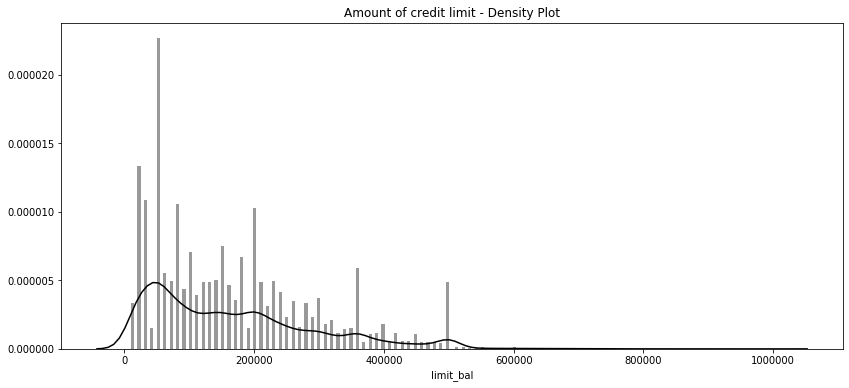

,limit_bal,values
0,50000,3365
1,20000,1976
2,30000,1610
3,80000,1567
4,200000,1528
...,...,...
76,800000,2
77,760000,1
78,690000,1
79,1000000,1


In [13]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("dark")
sns.distplot(df['limit_bal'],kde=True,bins=200, color="black")
plt.show()


temp = df["limit_bal"].value_counts()
df1 = pd.DataFrame({'limit_bal': temp.index,'values': temp.values})

df1


## Modelación

###  Importación de Librerias

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler


### Conjuntos de entrenamiento y prueba 

In [15]:
target = 'default'

X = df.drop('default', axis = 1)

robust_scaler = RobustScaler()

X = robust_scaler.fit_transform(X)

Y = df[target]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.15, random_state=123, stratify=Y)

-0.13231013495633764 0.0 0.498486784585379
